# 회귀 분석

In [1]:
# data 전처리

import pandas as pd
import numpy as np

data=pd.read_csv('Data_Science_Fields_Salary_Categorization.csv', index_col=0)
group_mapping = {
    "Data Engineer": [
        "Data Engineer", "Big Data Engineer", "Cloud Data Engineer", "Lead Data Engineer", 
        "Principal Data Engineer", "Data Engineering Manager", "ETL Developer", "Data Architect", 
        "Big Data Architect"
    ],
    "Data Scientist": [
        "Data Scientist", "Applied Data Scientist", "Principal Data Scientist", "Staff Data Scientist", 
        "Research Scientist", "AI Scientist", "Director of Data Science", "Head of Data Science", 
        "Data Science Manager", "Data Science Consultant", "Data Science Engineer"
    ],
    "Machine Learning Engineer": [
        "Machine Learning Engineer", "ML Engineer", "Machine Learning Developer", 
        "Machine Learning Scientist", "Applied Machine Learning Scientist", "Lead Machine Learning Engineer", 
        "Machine Learning Infrastructure Engineer", "Head of Machine Learning", "Machine Learning Manager", 
        "NLP Engineer"
    ],
    "Data Analyst": [
        "Data Analyst", "Business Data Analyst", "BI Data Analyst", "Financial Data Analyst", 
        "Marketing Data Analyst", "Product Data Analyst", "Lead Data Analyst", 
        "Principal Data Analyst", "Data Specialist", "Data Analytics Manager", 
        "Data Analytics Engineer", "Data Analytics Lead", "Analytics Engineer"
    ],
    "Computer Vision Engineer": [
        "Computer Vision Engineer", "3D Computer Vision Researcher", "Computer Vision Software Engineer"
    ]
}

def map_designation(designation):
    for group, titles in group_mapping.items():
        if designation in titles:
            return group
    return 'Other'

data['Group'] = data['Designation'].apply(map_designation)
data=data[data['Group'] != 'Other']
data_copy=data.copy()
data_copy['Salary_In_Rupees']=data['Salary_In_Rupees'].replace(',', '', regex=True).astype(float)
data_copy['Salary_Million_Won']=(data_copy['Salary_In_Rupees']*16.5/1000000).astype(int)
data=data_copy[['Working_Year','Experience','Employment_Status',
           'Employee_Location','Company_Location','Company_Size',
           'Remote_Working_Ratio','Group','Salary_Million_Won']]

# e-03 보다 크다면 과학적 표기법으로 쓰는 것이 아닌 일반 숫자 표시로 나타내도록
def conditional_format(x):
    if abs(x) < 1e-3:
        return f"{x:.3e}"  # 과학적 표기법
    else:
        return f"{x:.6f}"  # 일반 숫자 표시

# Pandas의 표시 형식에 조건부 포매팅 함수 적용
pd.options.display.float_format = conditional_format

In [2]:
# Employee_Location, Company Location 값에 따라 대륙별로 그룹화해주는 코드
# 그룹화를 위해 gpt 사용

# continent 값들읋 추가할 data_continent 생성
data_continent = data.copy()

# 국가 코드를 대륙으로 매핑하는 함수
from iso3166 import countries
import pycountry_convert as pcc

def map_to_continent(country_code):
    try:
        country_alpha2 = country_code.upper()
        continent_code = pcc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pcc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except KeyError:
        return "Unknown"
# Employee_Location에서 대륙 정보를 생성
data_continent['Employee_Continent'] = data_continent['Employee_Location'].apply(map_to_continent)
# Company_Location에서 대륙 정보를 생성
data_continent['Company_Continent'] = data_continent['Company_Location'].apply(map_to_continent)

data_continent

,Working_Year,Experience,Employment_Status,Employee_Location,Company_Location,Company_Size,Remote_Working_Ratio,Group,Salary_Million_Won,Employee_Continent,Company_Continent
1,2020,MI,FT,DE,DE,L,0,Data Scientist,104,Europe,Europe
2,2020,SE,FT,JP,JP,S,0,Machine Learning Engineer,341,Asia,Asia
3,2020,SE,FT,GB,GB,M,50,Data Engineer,143,Europe,Europe
4,2020,MI,FT,HN,HN,S,0,Data Analyst,26,North America,North America
5,2020,SE,FT,US,US,L,50,Machine Learning Engineer,196,North America,North America
...,...,...,...,...,...,...,...,...,...,...,...
603,2022,SE,FT,US,US,M,100,Data Engineer,202,North America,North America
604,2022,SE,FT,US,US,M,100,Data Engineer,165,North America,North America
605,2022,SE,FT,US,US,M,0,Data Analyst,169,North America,North America
606,2022,SE,FT,US,US,M,100,Data Analyst,196,North America,North America


In [5]:
import statsmodels.api as sm

# Categorical 변수를 수치형으로 변경(더미 변수화)
X = pd.get_dummies(data_continent[['Group', 'Experience', 'Company_Size', 
                         'Remote_Working_Ratio', 'Employment_Status', 
                         'Employee_Continent', 'Company_Continent']], drop_first=True)
X_const = sm.add_constant(X)
y = data['Salary_Million_Won']

# 회귀 분석
lm = sm.OLS(y, X_const).fit()

# 결과 요약
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:     Salary_Million_Won   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     23.31
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           2.44e-67
Time:                        03:57:12   Log-Likelihood:                -3349.6
No. Observations:                 596   AIC:                             6747.
Df Residuals:                     572   BIC:                             6853.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

## 회귀 분석 결과
- 경력(Experience)가 연봉에 가장 큰 영향을 미치는 변수로 나타난다.
- 대기업이 중소기업보다 높은 연봉을 제공한다.
- 미국(US) 직원의 연봉이 유의미하게 높다.

R-Squared는 0.563이지만 다중회귀분석이므로 변수의 수가 증가해 평가에 좋은 measure가 아니다.
변수의 수를 고려한 Adjusted R-Squared는 0.484로, 따라서 연봉(Salary)의 48.4%의 variance가 독립 변수들로 설명이 가능하다.



Experience_EX (Expert): 계수 158.35, p-value < 0.001
Experience_SE (Senior Level): 계수 61.23, p-value < 0.001
Experience_MI (Mid Level): 계수 32.63, p-value = 0.001

Remote_Working_Ratio(재택근무 비율): 계수 0.078, p-value > 0.05로 유의하지 않다.

Employment_Status(고용 상태): 고용 상태는 급여에 중요한 영향을 미치며, 특히 비정규직과 관련된 상태(FL, PT 등)는 급여를 낮추는 경향이 있다.
Employment_Status_PT(파트타임): -102.63 (p-value < 0.05)
Employment_Status_FL(계약직): -102.44 (p-value > 0.05)

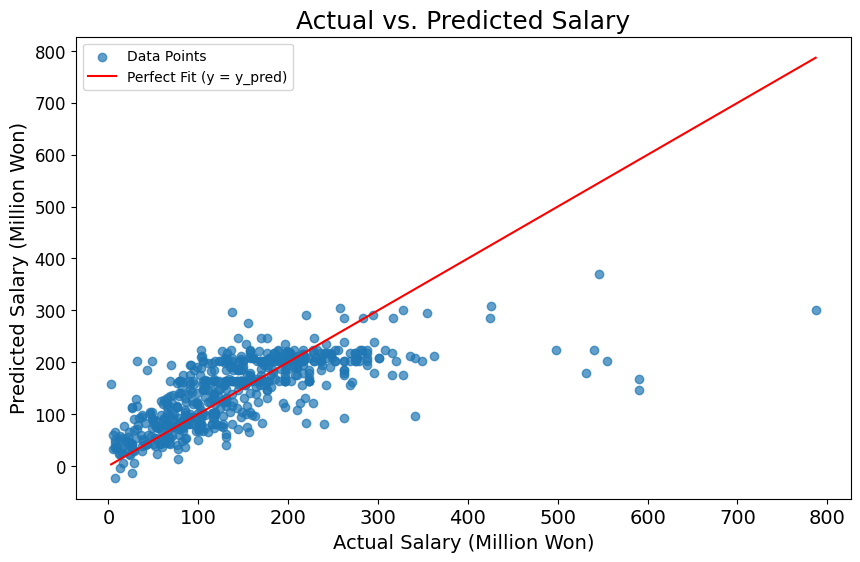

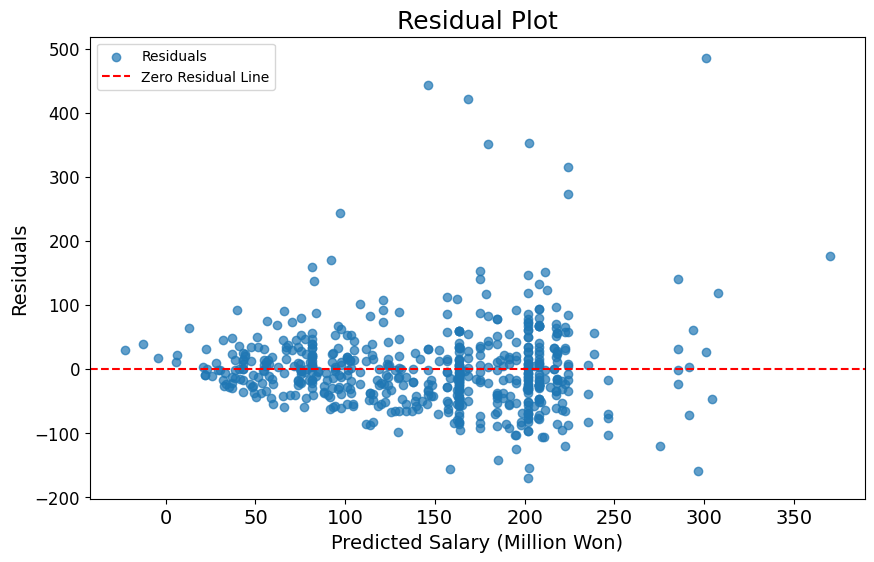

In [14]:
# 실제 급여와 예측된 급여를 비교하기 위해 GPT로 시각화를 진행하였습니다.

# 회귀 모델을 사용하여 예측 값 계산
y_pred = lm.predict(X_const)

# 잔차 계산 (잔차 = 실제 값 - 예측 값)
residuals = y - y_pred

# 실제 값 vs. 예측 값 그래프
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.7, label='Data Points')  # 실제 값과 예측 값을 산점도로 표시
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r', label='Perfect Fit (y = y_pred)')  # 이상적인 대각선 추가
plt.title('Actual vs. Predicted Salary')  # 그래프 제목
plt.xlabel('Actual Salary (Million Won)')  # x축 레이블
plt.ylabel('Predicted Salary (Million Won)')  # y축 레이블
plt.legend()
plt.show()

# 잔차 그래프
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7, label='Residuals')  # 예측 값과 잔차를 산점도로 표시
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')  # 잔차가 0인 기준선 표시
plt.title('Residual Plot')
plt.xlabel('Predicted Salary (Million Won)')
plt.ylabel('Residuals')
plt.legend()
plt.show()